# San Francisco Crimes.

The San Francisco crime dataset from DATASF provides a special opportunity to play with data visually and try to understand the underlying patterns present in it. Since the dataset covers a wide variety of crimes, visualizing them all at once might wash out any patterns contained in smaller subgroups. I have elected to see a subset of crimes wrapped in the array `focuscrimes`. This categories are going to be analysed temporally and geographically.


### Import Libraries and prepare jupyter environment for support visualization


In [46]:
from urllib.request import *
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import datetime
import folium
from folium.plugins import *
import branca.colormap
import seaborn as sns
from collections import defaultdict

sns.set(color_codes=True)
%matplotlib inline

import plotly.io as pio
pio.renderers.default='notebook'


## Part 1: Temporal Patterns

It's time to explore how the crime statistics change over time. Here we will explore the temporal development of only a subset of categories, the so-called focus crimes. Those categories are listed in the cell bellow. 

For this part the patterns will be explore with different time granularity.

Weekly patterns. Basically, we'll forget about the yearly variation and just count up what happens during each weekday. Some things make sense - for example drunkenness and the weekend. 

The months. We can also check if some months are worse by counting up number of crimes in Jan, Feb, ..., Dec. 

The 24 hour cycle. We'll can also forget about weekday and simply count up the number of each crime-type that occurs in the entire dataset from midnight to 1am, 1am - 2am ... and so on. 

Hours of the week. But by looking at just 24 hours, we may be missing some important trends that can be modulated by week-day, so let's also check out the 168 hours of the week. So let's see the number of each crime-type Monday night from midninght to 1am, Monday night from 1am-2am - all the way to Sunday night from 11pm to midnight.

#### Weekly pattern

In [47]:
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])

In [48]:
df = pd.read_csv("https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD", header='infer')

In [49]:
# Create timestamp for better management of date and time information
df['Timestamp'] = df[['Date', 'Time']].agg('-'.join, axis=1)
df['Timestamp']=pd.to_datetime(df['Timestamp'], format="%m/%d/%Y-%H:%M")

In [50]:
## Filter only by the focuscrimes categories
df1 = df[df["Category"].isin(focuscrimes) == True]

In [51]:
## Select data from 2013 forward
df1 = df1[df1["Timestamp"].dt.year > 2012]

In [52]:
# The "location" column is simply used for the count() aggregation function after the groupby, then
# this column is renamed to Cases
df_week = df1[["DayOfWeek","Category","location"]].groupby(["Category","DayOfWeek"], as_index=False).count()
df_week.columns = ["Category","DayOfWeek", "Cases"]

In [ ]:
rows = 7
cols = 2
fig = make_subplots(
rows=rows, cols=cols, subplot_titles=[i for i in focuscrimes],
vertical_spacing=0.08
)
categoryarray = df1.DayOfWeek.unique() # labels of the plot

i = 1; j = 0
for category in focuscrimes:
  j += 1
  section = df_week[df_week["Category"] == category]
  fig.add_trace(go.Bar(x=section["DayOfWeek"], y=section["Cases"]), row=i, col=j)
  if j == 2:
    j = 0 
    i += 1   

fig.update_layout(height=1400, width=800, showlegend=False)
fig.update_xaxes(categoryorder='array', categoryarray= categoryarray)


#### Weekly pattern visualization and analysis

In [54]:
fig.show()

In the above graphs we can see some clear increases in categories during the weekend. As one would expect Driving Under the Influence and Assault occur more often in the days where Drunkenness is also more present. These 3 categories are all linearly correlated in our opinion as when inhebriated physical alterations and driving tend to be more frequent. 
It is also interesting to see that Larceny/Theft and Burglary On Saturdays, we are led to thing that both are more frequent in those days as more people are outside, hence subject to theft and not home so at risk of burglary.
The peak in Prostitution on Thursdays is interesting but also under certain aspects could make sense as married men recurring to prostitution might be going out one last time before having to be spend the weekend with their family.

#### Monthly pattern

In [55]:
months = pd.DatetimeIndex(df1["Timestamp"]).month.to_numpy()
df1["Month"] = months

In [56]:
df_month = df1[["Month",'location']].groupby("Month", as_index=False).count()
df_month.columns = ["Month","Cases"]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=df_month["Month"], y=df_month["Cases"]))

fig.update_layout(xaxis_title="Month", yaxis_title="Crime cases")
fig.update_yaxes(type="log")
fig.update_xaxes(categoryorder='array', categoryarray= ["January","February",
                                                        "March","April","May",
                                                        "June","July","August",
                                                        "September","October","November","December"])
fig.update_layout(height=400, width=1000, showlegend=False)


#### monthly visualization and analysis

In [58]:
fig.show()

By doing some research and reading some scientific papers regarding the question at hand it seems like the overall consensus is that crime goes up with the heat. (examples like the number of Overall Revolutions happening in Europe during the summer are cited 167/495 in case you were wondering)
This does not seem to be the case with the data provided altough it might be interesting to consider how the single numbers for major chrimes change throughout the year (we would bet Burglary and Theft are going to peak in January as personal resources go up with Christmas presents)


#### 24 hour cycle

In [59]:
hours = pd.DatetimeIndex(df1["Timestamp"]).hour.to_numpy()
df1["Hour"] = hours

In [60]:
df_24hour = df1[["Category", "Hour", "location"]].groupby(["Category", "Hour"], as_index=False).count()
df_24hour.columns = ["Category", "Hour", "Cases"]

In [ ]:
rows = 7
cols = 2
fig = make_subplots(
rows=rows, cols=cols, subplot_titles=[i for i in focuscrimes],
vertical_spacing=0.05
)

i = 1; j = 0
for category in focuscrimes:
  j += 1
  section = df_24hour[df_24hour["Category"] == category]
  fig.add_trace(go.Bar(x=section["Hour"], y=section["Cases"]), row=i, col=j)
  if j == 2:
    j = 0 
    i += 1   

fig.update_layout(height=1400, width=800, showlegend=False)


#### 24 hour cycle visualization and analysis

In [62]:
fig.show()

We can see some interesting things analyzing all hours of the day.
- Vehicle Theft/ Larceny/ Burglary and Robbery have similar trends with some minor differences, but in general they seem to be more frequent around 18 pm and in the first hours of the night. This again makes perfect sense although it is interesting how low the amount of vehicle thefts late at night is, we would it expect it to be slightly higher.
- It is also interesting to notice the difference between Drunkenness and Drug/Narcotic, we would expect the behaviours to be fairly similar but they are actually in stark contrast. While Drunkennes clearly has peaks around the end of the day, Narcotics seem to be more widely used (or the people buying caught) around what in America is dinner time at 5.6. pm. 

####Hours of the week

In [63]:
df1["hourofweek"] = (pd.DatetimeIndex(df1["Date"]).weekday*24 )+df1["Hour"].astype(float)

In [64]:
df_weekhour = df1[["Category", "hourofweek", "location"]].groupby(["Category", "hourofweek"], as_index=False).count()
df_weekhour.columns = ["Category", "Hourofweek", "Cases"]

In [ ]:
rows = 7
cols = 2
fig = make_subplots(
rows=rows, cols=cols, subplot_titles=[i for i in focuscrimes],
vertical_spacing=0.05,
)

i = 1; j = 0
for category in focuscrimes:
  j += 1
  section = df_weekhour[df_weekhour["Category"] == category]
  fig.add_trace(go.Bar(x=section["Hourofweek"], y=section["Cases"], width=1), row=i, col=j)

  if j == 2:
    j = 0 
    i += 1   

fig.update_layout(height=1400, width=1200, showlegend=False)


####Weel hourly visualization and analysis 

In [66]:
fig.show()

Overall for crimes regarding alcohol we can see roughly what was easy to comprehend from the previous graphs too, peaks on weekends in the evenings. The same can be seen with Burglary and Robbery (again, more people outside their homes). 
It is also interesting to note the similarity of Disorderly Conduct and Trespassing with both seemingly very frequent in the period within 7 am and 10 am and especially on the first three days of the week. 
Lastly we can notice and incredible peak on Thursdays regarding Prostitution. We further analyze this in the last point of the exercise but such a big difference is probably due to a mistake in recording the infractions (or on the database).

## Part 2: Jitter plot


Here we make a jitter-plot choosing a crime-type and a suitable time sub-sample to show when is concentrated more of the arrest times during a single hour.

Firstly, we filter the category with more density of cases in order to have a more visual jitter.

In [67]:
Selection=(df.groupby(['Category'])
        .agg({'Y': 'mean', 'Category': 'count'}))
display(Selection['Category'].sort_values(ascending=False).head(1))

Category
LARCENY/THEFT    477975
Name: Category, dtype: int64

After choosing the category Larceny/Theft, we filter for a suitable time interval with Year 2016, months from July to december and time from 18:00 to 18:59. 

/tmp/ipykernel_25728/1855090585.py:12: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




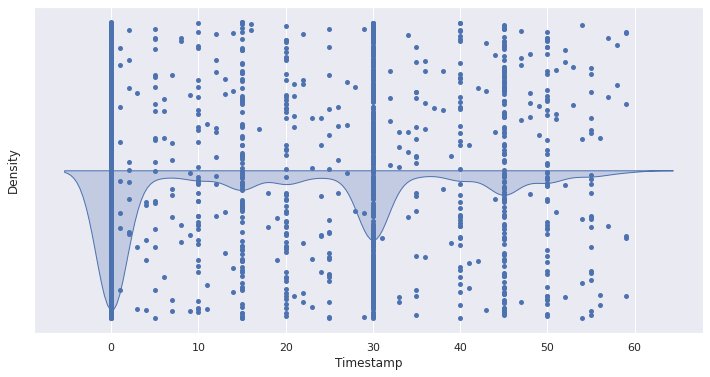

In [68]:
df_LT_sample = df.loc[((df.Category == 'LARCENY/THEFT') 
                       &(df['Timestamp'].dt.year == 2016)
                       &(df['Timestamp'].dt.month > 6)
                       &(df['Timestamp'].dt.hour == 18)), ['Timestamp']]

plt.figure(figsize = [12, 6])

ax = sns.stripplot( x = df_LT_sample['Timestamp'].dt.minute)

#Addition of density function to the jitter plot for a better distinguishing the most frequent minutes.

ax = sns.kdeplot(data = df_LT_sample['Timestamp'].dt.minute , bw_method= 0.1, shade=True, color="b");


We can visualize in the jitter plot that the density of cases on round time are bigger. This gave us a notion of the behaviour pattern of how San Francisco police annotate the crime time rather than the crime distribution minute-wise.

## Part 4: Geo-data

#####Histogram Analysis

Firstly, we will observe and understand the GPS data through some histograms 
For that we will pick two crime-types with different geographical patterns and a suitable time-interval subsample (between 1000 and 10000 points per histogram)
Then we take the latitude part of the GPS coordinates for each crime and bin the latitudes so that we have around 50 bins across the city of SF.

One option to get different patterns would be plot all the histograms. However, it is important in this project to make it as compact as possible

In [69]:
display(Selection['Y'][(Selection['Category']>=1000)&(Selection['Category']<=10000)].sort_values(ascending=False))

Category
DISORDERLY CONDUCT             37.782273
KIDNAPPING                     37.774333
LOITERING                      37.773842
SEX OFFENSES, FORCIBLE         37.772659
EMBEZZLEMENT                   37.770820
DRUNKENNESS                    37.770649
LIQUOR LAWS                    37.767707
SUICIDE                        37.766082
DRIVING UNDER THE INFLUENCE    37.765672
ARSON                          37.757443
RECOVERED VEHICLE              37.754797
Name: Y, dtype: float64

As result of this exploration we choose to visualize DISORDERLY CONDUCT and RECOVERED VEHICLE which have the most different values between the categories above. Additionally, we noticed that there is some cases with an error in the location. We solve this error by filtering under a boundarie of 40 degrees of longitud.

In [70]:
df_hist_sample = df[(df['Category'].isin(['DISORDERLY CONDUCT', 'RECOVERED VEHICLE'])) 
                   & (df.Y <40.0)]

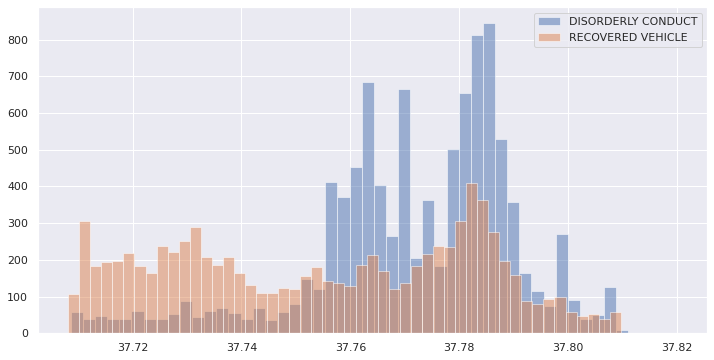

In [71]:
#numpy.histogram
hist1, bin_edges1= np.histogram(df_hist_sample[df_hist_sample.Category == 'DISORDERLY CONDUCT'].Y, bins=50)
hist2, bin_edges2= np.histogram(df_hist_sample[df_hist_sample.Category == 'RECOVERED VEHICLE'].Y, bins=50)

#plot
fig = plt.figure(figsize = [12, 6])
ax = plt.hist(df_hist_sample[df_hist_sample.Category == 'DISORDERLY CONDUCT'].Y, bins = bin_edges1, alpha = 0.5);
ax = plt.hist(df_hist_sample[df_hist_sample.Category == 'RECOVERED VEHICLE'].Y, bins = bin_edges2, alpha = 0.5);
plt.legend(labels = ['DISORDERLY CONDUCT', 'RECOVERED VEHICLE']);

We can observe in the graph that as we guessed we found different patterns for the choosen categories. Both of them has high density around 37.78 degrees, being the one from disorderly conduct double the cases around this area. however, as soon as we decrease on lattitude, there is an abrupt decrease in the number of cases belonging to the disorderly conduct while in recovered vehicles the level of density stay more constant.

#####GEOJson visualization with Folium

A new take on geospatial data using Folium.

Now we look at studying geospatial data by plotting raw data points as well as heatmaps on top of actual maps.

In [72]:
"""Generate folium San Francisco base map with Stamen toner tile """
def generateBaseMap(default_location=[37.77919, -122.41914], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, 
                          zoom_start=default_zoom_start, tiles="Stamen toner")
    return base_map
base_map = generateBaseMap()

The coordinates for SF City Hall are `37.77919, -122.41914`. To indicate its location on the map, we set a pop-up enabled maker. 

For the following visualization, we will show a clustered scatter plot over the map. This time we focus on a couple of months of data for `'DRUG/NARCOTIC'` and draw a data point pop-up marker for each arrest for those two months. The points cluster together in the mass center when the map is zoom out showing the number of crimes clustered. In addition,when posing the cursor on the cluster it shows the clustering area. On the contrary, if we zoom in the point become a marker which can be clicked to display  usefull information about that specific crime.


In [73]:
# Select DRUG/NARCOTIC category in June-July 2016 
df2 = df[(df["Category"]=="DRUG/NARCOTIC") 
         & (pd.DatetimeIndex(df["Date"]).month.isin([6,7])) 
         & (pd.DatetimeIndex(df["Date"]).year == 2016)]

In [74]:
""" Displays the code and time of the crime as additional info for the plot markers """
def crime_info(row):
    incident_code = str(row["Incident Code"])
    date = str(row["Date"])
    time = str(row["Time"])
    
    info = "Inc.Code: " + incident_code+" Date: "+date+" "+time
    return info

In [75]:
"""Creates array of coordinates to input folium map marker map"""
def to_coordinates(row):
    return [row["Y"],row["X"]]

In [76]:
coord = df2.apply(to_coordinates,axis=1).to_numpy().tolist() # Coordinates of the crimes
info = df2.apply(crime_info, axis=1).to_numpy().tolist() # Crime info

base_map = generateBaseMap()
marker_cluster = folium.plugins.MarkerCluster().add_to(base_map) # Generate marker clusters for better visualization
for i in range(len(coord)):
    folium.Marker(location=coord[i], popup=info[i]).add_to(marker_cluster) # Add crime marker to the map
    
base_map

## Part 5: Errors in the data. The importance of looking at raw (or close to raw) data.

Sometimes the binning can hide imprecision, irregularity, and simple errors in the data that could be misleading. In the work we've done so far, we've already come across at least three examples of this in the SF data. In addition, the 3 data errors we discovered become difficult to notice when we aggregate data (and when we calculate mean values, as well as statistics more generally). Thus, when we visualize, errors become difficult to notice when when we bin the data. We explore this process in final part of the analysis. Since, they can bias the binned versions of the data. Also briefly mention how not noticing these errors can result in misconceptions about the underlying patterns of what's going on in San Francisco (and our modeling).

####1. Anomaly in prostitution on Thursdays

In the hourly activity for PROSTITUTION something surprising is going on on Thursday. The anomaly in PROSTITUTION cases occurs during an specific hour and drastically drops in the next. While the overall activity of PROSTITUTION remains higher during Thursdays than the rest of the days, this specific hour behaviour is weird and can be caused by wrongly registered outliers in the dataframe or a specifics activities carried out by the police towards stopping this type of crime.

In [77]:
thursdayhour_events = df1[df1["hourofweek"] == 84][["Date", "hourofweek"]].groupby("Date", as_index=False).count()
thursdayhour_events.columns = ["Date", "Cases"]
tonumpy = thursdayhour_events["Cases"].to_numpy()

Mean: 12.18 	 Stand. Dev: 5.50 	


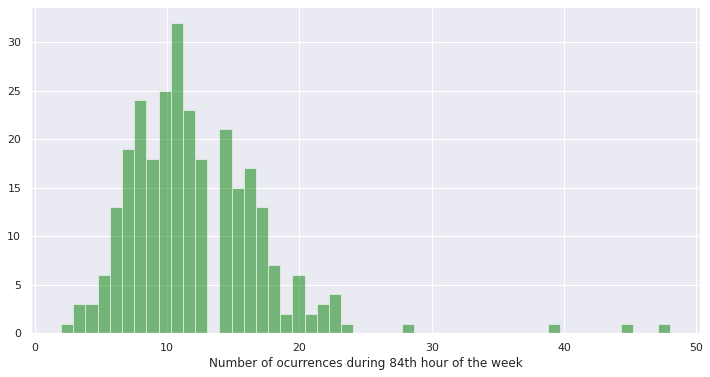

In [78]:
mu = np.mean(tonumpy)
sig = np.std(tonumpy)
max_day = np.max(tonumpy)

plt.figure(figsize = [12, 6])
plt.hist(tonumpy, bins = 50,
              alpha = 0.5, color="green");
plt.xlabel("Number of ocurrences during 84th hour of the week")

print("Mean: %1.2f \t" %mu, "Stand. Dev: %1.2f \t" %sig)

As we can see in the histogram the normal number of PROSTITUTION incidences in the 84th hour of the week is normally between 6 to 18 incidences. Nevertheless we can see some cases when the number of incidences in this particular hour is particurlarly high (reaching close to 50 incidences in the same hour). 

Let's consider outliers all number of ocurrences that separate more than 2$\sigma$ from the mean ($\mu$), that is all the number of incidences ~>25 and ~<1 and see what happens.

In [79]:
thursdayhour_events_outliers = thursdayhour_events[(thursdayhour_events["Cases"]>25) 
                                                   | (thursdayhour_events["Cases"]<1)]
outlier_dates = thursdayhour_events_outliers["Date"].to_numpy()

We will repeat the last part of the first exercise but trimming these outliers

In [80]:
## Filter only by the focuscrimes categories
df1 = df[df["Category"].isin(focuscrimes) == True]

In [81]:
## Select data from 2013 forward
df1 = df1[df1["Timestamp"].dt.year > 2012]

In [82]:
## Drop outliers
df1.drop(df1[(df1["Date"].isin(outlier_dates)) & (df["Category"]=="PROSTITUTION")].index, inplace=True)

/tmp/ipykernel_25728/2854002743.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [83]:
hours = pd.DatetimeIndex(df1["Timestamp"]).hour.to_numpy()
df1["Hour"] = hours
df1["hourofweek"] = (pd.DatetimeIndex(df1["Date"]).weekday*24 )+df1["Hour"].astype(float)

In [84]:
df_weekhour = df1[["Category", "hourofweek", "location"]].groupby(["Category", "hourofweek"], as_index=False).count()
df_weekhour.columns = ["Category", "Hourofweek", "Cases"]

In [85]:
## Zoom in PROSTITUTION category
section = df_weekhour[df_weekhour["Category"] == "PROSTITUTION"]
fig = go.Figure(go.Bar(x=section["Hourofweek"], y=section["Cases"], 
                       width=1, marker_color="#FFA15A"))
fig.update_layout(xaxis_title="Hour of the week",
                  yaxis_title = "Cases", height=400, width=1000, title="PROSTITUTION")
fig.show()

Without the outlier events, the number of incidences in the 84th hour of the week has shrunk noticeably. This could possibly mean that there were a few days when the number of PROSTITUTION incidences suddenly spiked (for unknown reasons) or, on the other hand, there were some error in the registration of these crimes and we could consider them as outliers of the distribution.

####2. Anomaly in recorded time of the crime

When we investigated the details of how the timestamps are recorded using jitter-plots, we saw that many more crimes were recorded on the hour, 15 minutes past the hour, and to a lesser in whole increments of 10 minutes. Crimes didn't appear to be recorded as frequently in between those round numbers. The crime times are rounded up to the  closes 15 minutes, being more notorious at half the hour and the exact hour.  In order to cope with this we have to increase the bin width to ensure that a given peak remains in its bin despite the shifting. That make confront the recognition of a pattern or underlying distribution, so that, it is important to conserve a balance.

####3. Unlikely congragation of sex offences in the hall of justice

The Hall of Justice seemed to be an unlikely hotspot for sex offences. If we plot the heatmap we can observe an unique spot assigned to multiple different crimes.

In [86]:
df2 = df[df["Category"] == "SEX OFFENSES, NON FORCIBLE"]
base_map = generateBaseMap()
# We add a marker with a popup sentence and a different type, we chose info-sign with color blue.
folium.Marker(location=[37.775471, -122.403717], popup="City Hall",
              icon=folium.Icon(color="blue", icon="info-sign"),).add_to(base_map)
HeatMap(data=df2[['Y', 'X', 'location']].groupby(['Y', 'X']).count().reset_index().values.tolist(), 
        radius=15, max_zoom=10).add_to(base_map)
base_map

At first we could argue this might be a rounding problem of the Folium function itself, but that might not be the case. If we take a look at the length of the filtered dataframe (df2):

In [87]:
print("Dataframe length:", len(df2), "\nNumber of unique longitudes:", len(df2.X.unique()), 
      "\tNumber of unique latitudes:", len(df2.X.unique()) )

Dataframe length: 43 
Number of unique longitudes: 40 	Number of unique latitudes: 40


The number of unique longitudes and latitudes is lower than the dataframe length, which means that the same coordinates have been assigned to different crimes. The reason on this flaw in the dataframe is unknown and can be possibly caused by human mistakes or to rounding issues in the dataframe registration of the latitudes and logitudes.